In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
xr.set_options(keep_attrs=True)
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/analysis_antarctic-asym/analysis/')
import asym_funcs as af
from haversine import inverse_haversine, Direction
from math import pi


Compute SIE from HADISST (because it's on a regular grid)

In [2]:
wdir = '/glade/work/lettier/HADISST/'

In [3]:
ds = xr.open_dataset(wdir+'HadISST_ice_1979-2016.nc').groupby('time.month').mean(dim='time')

In [4]:
garea, _, _ = af.grid_area_regll(ds.latitude,ds.longitude) # compute area of these grid cells
garea = xr.DataArray(-garea, dims=['latitude','longitude'],
                  coords = {'latitude':ds.latitude, 'longitude':ds.longitude}).to_dataset(name='gridcellarea')


In [5]:
ints = ds.sic.where(ds.sic>.15)
ints = ints/ints

In [6]:
sie_sh = (ints*garea.gridcellarea).where(garea.latitude<0).sum(dim=('latitude','longitude'))

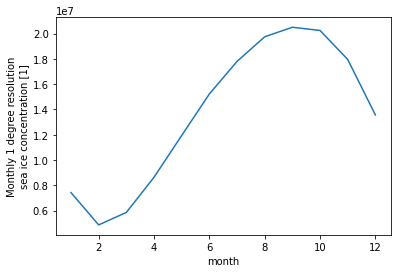

In [7]:
sie_sh.plot()

Compute zonal mean ice edge - as Eisenman (2010)

In [8]:
landmask = xr.open_dataset(wdir+'/landmask.nc').sftlf
lats = np.linspace(-89.5,89.5,10*180) # 0.1 degree grid
lons = np.linspace(-179.5,179.5,10*360)

garea, _, _ = af.grid_area_regll(lats,lons) # compute area of these grid cells
ds = xr.DataArray(garea,dims=['latitude','longitude'],coords = {'latitude':lats, 'longitude':lons}).to_dataset(name='gridcellarea')


landmaskhighres = landmask.interp(latitude=lats)
landmaskhighres = landmaskhighres.interp(longitude=lons)

oceanarea = (ds.gridcellarea*(1.-landmaskhighres)).sum(dim='longitude')
oareash = oceanarea.where(oceanarea.latitude<0.,drop=True)

oareash['latitude'] = -oareash.latitude
oshc = oareash.cumsum(dim='latitude')

# subtract sea ice extent from ocean area
diffsh = (oshc - sie_sh)
diffsh = diffsh.where(diffsh>0.)

icedge_sh = -(diffsh.latitude.where(diffsh==diffsh.min(dim='latitude')).max(dim='latitude'))



- values from Brouwer paper - MIZ width in km
- https://tc.copernicus.org/preprints/tc-2021-367/tc-2021-367.pdf
- approximate readings from Fig. 19, exponential FIRF

In [9]:

mydict = {}
mydict[2] = 50
mydict[5] = 180
mydict[9] = 250
mydict[12] = 75

mylatdict = {}

Compute (zonal mean) latitudes inside ice edge that MIZ extends to (using inverse Haversine)

2 50
2
5 180
5
9 250
9
12 75
12


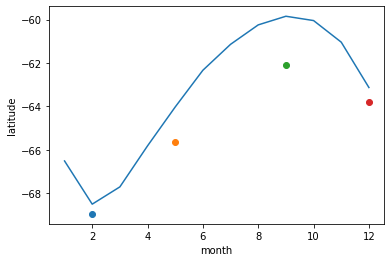

In [10]:
fig, ax = plt.subplots(1)
icedge_sh.plot(ax=ax)

mylats = []
for mon in mydict:
    print(mon,mydict[mon])
    pt1 = (icedge_sh.sel(month=mon), 100) # (lat, lon)
    miz_lat, _ = inverse_haversine(pt1, mydict[mon], Direction.SOUTH)
    ax.scatter(mon,miz_lat)
    print(mon)
    mylatdict[mon] = miz_lat

plt.show()

Compute wave affected extent as the area between latitude of sea ice edge and latitude that MIZ width extends to

In [11]:
for mon in mydict:
    wave_affect_ext = ds.gridcellarea.where(ds.latitude>mylatdict[mon]).where(ds.latitude<icedge_sh.sel(month=mon)).sum(dim=('latitude','longitude'))/1e6
    
    print(str(mon)+', {:.2f} million km^2'.format(wave_affect_ext.values))

2, 0.64 million km^2
5, 3.00 million km^2
9, 4.71 million km^2
12, 1.18 million km^2
